# Practical 2 : Generative and Discriminative Models

**Quick report on proceeding and contributions**<br/>
Compared to the first practical where everyone of us was working on the tasks from the beginning, we decided to split the group, such that Giuseppe and Maida worked together on the practical 2 and Jan worked on practical 3. Within the task of this practical however we encountered more difficulties than for practical 1, where the statistical as well as conceptual arguments were familiar. Hence here it was necessary to focuss more extensively on the lecture notes and get familiar with the implementation of the calculations required. Maida and Giuseppe managed to implement the distriubtions, the logistic regression and to prepare all data sets. For the NBC they knew intuitively what to do, nevertheless they could not manage to implement the NBC. Here is where Jan's contribution starts: At the end he was the one implementing the NBC, while Giuseppe and Maida wrapped up the practical by writing the reports below each data set.
Summed up our by far biggest difficulty for this practical was the implementation of the NBC, while all other tasks were managable.


In this practical, we will compare the Naïve Bayes Classifier (NBC) and Logistic Regression on six
datasets. As part of the practical you should briefly read the following paper:



**On Discriminative vs. Generative classifiers: A comparison of logistic regression
and naive Bayes**  
*Andrew Y. Ng and Michael I. Jordan*  
Advances in Neural Information Processing Systems (NIPS) 2001.

The paper is available on OLAT. 

You should read the Introduction and the Experiments sections. The goal of this practical is
to qualitatively reproduce some of the experimental results in this paper. You are strongly
encouraged to read the rest of the paper, which is rather short and straightforward to read,
though some of you may want to skip the formal proofs.

## 1.1 Naïve Bayes Classifier

You should implement a Naïve Bayes Classifier directly in python. To keep your code tidy,
we recommend implementing it as a class. Make sure that your classifier can handle binary, continuous and categorical features, and an arbitrary number of class labels. Suppose the data has 3
different features, the first being binary, the second being continuous and the third being categorical, and that there are
4 classes. Write an implementation that you can initialise as follows:

    nbc = NBC(feature_types=['b', 'r', 'c'], num_classes=4)

Along the lines of classifiers provided in sklearn, you want to implement two more functions,
**fit** and **predict**. 
Recall the joint distribution of a generative model: $p(\mathbf{x}, y \mid \theta, \pi) = p(y | \pi) \cdot p(\mathbf{x} \mid y, \theta)$.
The fit function is expected to estimate all the parameters ($\theta$ and $\pi$) of the NBC. The predict function is expected to compute the probabilities that the new input belongs to all classes and
then return the class that has the largest probability.

    nbc.fit(X_train, y_train)
    ypredicted = nbc.predict(X_test)
    test_accuracy = np.mean(ypredicted == ytest)

Here we import the libraries. 

In [1]:
%matplotlib inline
import pylab
pylab.rcParams['figure.figsize'] = (10., 10.)
import math as mt
import doctest
import pickle as cp
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from math import log
from math import e
from scipy.stats import bernoulli
from scipy.stats import multinomial
from scipy.stats import norm
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder()

In [2]:
verbose = 0

Before implementing NBC, we suggest you first implement the three types of the distributions of the parameters of NBC. Your implementation should have two functions: **estimate** and **get_probability**. The estimate function takes some data as input and computes the maximum likelihood estimators (MLE) for the parameters $\theta$ of the distribution $p(x | \theta)$. The get_probability function takes a new input value $x_{new}$ and returns $p(x_{new} | \theta)$. For example, in the case of continuous features, we can use the Gaussian distribution. The estimate function will find the parameters $\mu$ and $\sigma$ for the Gaussian distribution with respect to the input data, and the function get_probability will return $\mathcal{N}(x_{new} \mid \mu, \sigma)$. 

![alt text](pics/mle_4.png)


In [3]:
# Distribution for continuous features
class ContFeatureParam:
    def estimate(self,X):
        self.mean, self.std = norm.fit(X)
        
        # If the calculated variance is close to zero
        # then we need to set it to a small value
        # in order to avoid division by zero errors.
        if (self.std < 10^(-3)):
            self.std = 10^(-3)
          
        return (self.mean, self.std)
    
    
    def get_probability(self, val):
        proba = norm.pdf(val, loc=self.mean, scale = self.std)
        #print("Value %s on (%s, %s) => Likelihood %s" % (val, self.mean, self.std, proba))
        return proba
    
    
    def show_diagram(self, data, class_name, feature_name): 
        plt.figure(figsize=(3,3))
        plt.hist(data, bins=25, density=True, alpha=0.4, color='b')
        xmin, xmax = plt.xlim()
        x = np.linspace(xmin, xmax, 100)
        p = norm.pdf(x, self.mean, self.std)
        plt.plot(x, p, 'r', linewidth=2, alpha=1.0)
        title = "Class %s > Feature %s \n µ = %.2f,  σ = %.2f" % (class_name, feature_name, self.mean, self.std)
        plt.title(title)
        plt.show()


# Distribution for binary features
class BinFeatureParam:
    def estimate(self, X):
        self.p=np.mean(X)
        
    def get_probability(self,val):
        self.pdfbernoulli = bernoulli.pmf(val,p=self.p)
        return self.pdfbernoulli

    def show_diagram(self, data, class_name, feature_name): 
        print("not yet implemented")

# Distribution for categorical features
class CatFeatureParam:

    def __init__(self, feature_manifestations):
        self.feature_manifestations = feature_manifestations
        
    #if __name__ == '__main__':
    #    #doctest.testmod(extraglobs={'t': CatFeatureParam()}, verbose=False)
    #    print("test")
   
    def estimate(self, data):
        occurences = np.zeros(self.feature_manifestations)
        # Identify individual classes and their absolute occurences
        feature_values, count = np.unique(data, return_counts=True)
        for i in range(len(feature_values)):
            occurences[int(feature_values[i])] = count[i]
        N = len(data)
        self.num_feature_values = len(feature_values)
        # Divide the individual class occurence through the total number of elements
        self.feature_probabilities = np.array(occurences)/N
        #print(self.feature_probabilities)
        return {feature_values[i]: occurences[i]/N for i in range(len(feature_values))}

    #takes a new input value $x_{new}$ and returns $p(x_{new} | \theta)$
    def get_probability(self, category):
        #return multinomial.pmf(category, p=self.feature_probabilities, n=1)
        return self.feature_probabilities[category]

    def show_diagram(self, data, class_name, feature_name): 
        print("not yet implemented")
    

        

**Hints for function fit**: Recall the joint distribution of a generative model: $p(\mathbf{x}, y \mid \theta, \pi) = p(y | \pi) \cdot p(\mathbf{x} \mid y, \theta)$. 
The fit function will estimate the parameters for NBC based on the training data. 
Here we give you some hints how to estimate the $\theta$ in $p(\mathbf{x} \mid y, \theta)$. 

For each class $c$, we want to estimate the $\theta_c$ for the distribution $p(\mathbf{x} \mid y = c, \theta_c)$. 
Since the assumption of NBC that the features are conditionally independent given the class $c$, the class conditional distribution is a product of $D$ distributions, one for each feature: $p(\mathbf{x} \mid y = c, \theta_c) = \prod_{j}^{D} p(x_j \mid y = c, \theta_{jc})$. Hence, we need to estimate the $\theta_{jc}$ based on the data with class $c$ and feature $j$. 

**Hints for function predict**: The predict function should compute the probabilities $p(y = c \mid \mathbf{x}_{new}, \pi, \theta)$ for the new inputs $\mathbf{x}_{new}$ on all classes by applying the Bayes rule:

$$p(y = c \mid \mathbf{x}_{new}, \pi, \theta) = \frac{p(y = c \mid \pi_c) \cdot p(\mathbf{x}_{new} \mid y=c, \theta)}{\sum^{C}_{c'=1}p(y=c' \mid \pi_{c'}) \cdot p(\mathbf{x}_{new} \mid y=c', \theta_{c'})},$$

and then return the class that has the largest probability:

$$y_{predict} = \underset{c}{arg\,\max} \, {p(y = c \mid \mathbf{x}_{new}, \theta_c)}.$$

Here we give you some hints on the computation of $p(\mathbf{x}_{new} \mid y=c, \theta_c)$. 
Due to the conditional independence assumption, we have $p(\mathbf{x}_{new} \mid y=c, \theta_c) = \prod_{j}^{D} p(x^j_{new} \mid y = c, \theta_{jc})$. Since we have got the parameters $\theta_{jc}$ in the fit phase,  we can use them to compute the probabilities for the new data. 

**Implementation Issues**
- Fell free to add auxiliary functions. 
- Don't forget to compute $p(y=c | \pi)$ 
- Remember to do all the calculations in log space to avoid running into underflow issues. Read more: (Mur) Chapter 3.5.3
- Your implementation should be able to handle missing values
- As far as possible use matrix operations. So assume that Xtrain, ytrain, Xtest will all
be numpy arrays. Try and minimise your use of python loops. (In general, looping over
classes or features is OK, but looping over data is probably not a good idea.)
- The variance parameter for Gaussian distributions should never be exactly 0, so in
case your calculated variance is 0, you may want to set it to a small value such as 1e − 6.
Note that this is essential to ensure that your code never encounters division by zero or
taking logarithms of 0 errors. Also, you want to ensure that the estimates for the parameter for the Bernoulli or Multinoulli random variables
is never exactly 0 or 1. For this reason you should consider using Laplace smoothing (https://en.wikipedia.org/wiki/Additive_smoothing).


In [4]:
class NBC:
    # Inputs:
    #   feature_types: the array of the types of the features, e.g., feature_types=['r', 'r', 'r', 'r']
    #   num_classes: number of classes of labels
    def __init__(self, feature_types=[], num_classes=0):
        #print(feature_types)
        #print(len(feature_types))
        self.feature_types = feature_types
        self.num_classes = num_classes
        
    # Split the dataset by class values, returns a dictionary
    def seperate_by_class(self, X, y):
        separated = {}
        for i in range(len(X)):
            observation = X[i]
            class_label = y[i]
            if class_label not in separated:
                separated[class_label] = np.empty((0,X.shape[1]))
            separated[class_label] = np.vstack([separated[class_label], observation])
        return separated
 

    def calculate_priors(self, data):
        # Identify individual classes and their absolute occurences
        classes, occurences = np.unique(data, return_counts=True)
        N = len(data)
        # Divide the individual class occurence through the total number of elements
        return {classes[i]: occurences[i]/N for i in range(len(classes))}

    # The function uses the input data to estimate all the parameters of the NBC
    # You should use the parameters based on the types of the features
    def fit(self, X, y):
        self.likelihoods = {}
        self.prior_class_probabilities = self.calculate_priors(y)
        class_observations = self.seperate_by_class(X, y)
        
        for class_label in class_observations:
            observations_in_class = class_observations[class_label]
            #print("Class_label ", class_label)
            
            if class_label not in self.likelihoods:
                self.likelihoods[class_label] = {}
            
            for i in range(len(self.feature_types)):
                
                feature_type = self.feature_types[i]
                #print("Feature_type", feature_type)
                #print("Feature_index", i)
                feature = observations_in_class[:,i]
                
                # If the feature values are binary
                if feature_type == 'b':
                    dist = BinFeatureParam()

                # If the feature values are categorical
                if feature_type == 'c':
                    feature_manifestations = len(np.unique(X[:,i]))
                    #print("Feature %s has heature manifestation %s" % (i, feature_manifestations))
                    dist = CatFeatureParam(feature_manifestations)

                # If the feature values are continous
                if feature_type == 'r':
                    dist = ContFeatureParam()
                    
                #print("Feature", feature)
                dist.estimate(feature)
                if verbose:
                    dist.show_diagram(feature, class_label, i)
                self.likelihoods[class_label][i] = dist
                         
                
    # The function takes the data X as input, and predicts the class for the data
    def predict(self, X):
        # Loop over all prior class probabilities P(y=c|Pi_c)
        posterior_class_probabilities = list()
        total_probability = 0

        # Calculate log of posterior probability as
        # P(y=c|X_new, π, θ) = P(y=c|π_c)*P(X_new|y=c, θ)
        for class_name, prior_class_probability in self.prior_class_probabilities.items():
            #print("CLass %s Prior %s / Log Prior %s" % (class_name, prior_class_probability, log(prior_class_probability)))
            posterior_class_probability = log(prior_class_probability)
            for i in range(len(self.feature_types)):
                #print(len(self.feature_types))
                #print("Number", i)
                cur_feature = X[i]
                prob_dist = self.likelihoods[class_name][i]
                feature_probability = prob_dist.get_probability(cur_feature)
                if(feature_probability > 0):
                    posterior_class_probability += log(feature_probability)
                    #print("CLass %s Feature %s (val %s) Likelihood %s / Log Likelihood %s" % (class_name, i, cur_feature, feature_probability, log(feature_probability)))
                else:
                    posterior_class_probability = -10000000
            posterior_class_probabilities.append(posterior_class_probability)
            total_probability += posterior_class_probability
        #print("Posteriors %s" %(posterior_class_probabilities))
        return np.argmax(np.array(posterior_class_probabilities))
    
    
    def predict_v(self, X):
        n = X.shape[0]
        y_hat = np.empty(n)
        
        for k in range(n):
            y_hat[k] = self.predict(X[k])
        
        return y_hat

## 1.2 Logistic Regression

For logistic regression, you should use the implementation in sklearn. Adding the following
line will import the LR model.

    from sklearn.linear_model import LogisticRegression

Read the information provided on the following links to understand some details about how the
logistic regression model is implemented in scikit-learn.
- http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
- http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression


In [5]:
#Import model
from sklearn.linear_model import LogisticRegression

class LR:
    model = None
    
    def __init__(self):
        self.model = LogisticRegression(random_state=0)
            
    def fit(self, X, y):
        self.model.fit(X, y)
    
    def predict(self, X):
        return self.model.predict(X)

## 2. Comparing NBC and LR

You will compare the classification error of the NBC and LR trained on increasingly
larger training datasets. Because the datasets are so small, you should do this multiple times and
average the classification error. One run should look as follows:
- Shuffle the data, put 20% aside for testing.
    
    ```N, D = X.shape
    Ntrain = int(0.8 * N)
    shuffler = np.random.permutation(N)
    Xtrain = X[shuffler[:Ntrain]]
    ytrain = y[shuffler[:Ntrain]]
    Xtest = X[shuffler[Ntrain:]]
    ytest = y[shuffler[Ntrain:]]
    
    ```  


- Train the classifiers with increasingly more data. For example, we can train classifiers with 10%, 20%, ..., 100% of the training data. For each case store the classification errors on the test set of the classifiers.

You may want to repeat this with at least 200 random permutations (possibly as large as 1000)
to average out the test error across the runs. In the end, you will get average test errors as a
function of the size of the training data. Plot these curves for NBC and LR on the datasets.

Tasks: For each dataset,
1. prepare the data for the two classifiers
2. compare the two classifiers on the dataset and generate the plots
3. write a short report of how you prepare the data and your observations of the comparison


In [6]:
# inputs:
#   nbc: Naive Bayes Classifier
#   lr: Logistic Regression Classifier
#   X, y: data
#   num_runs: we need repeat num_runs times and store average results
#   num_splits: we want to compare the two models on increasingly larger training sets.
#               num_splits defines the number of increasing steps. 
# outputs:
#   the arrays of the test errors across the runs of the two classifiers 

# At first we do the train test split and then we run for the specified number of iterations.
def compareNBCvsLR(nbc, lr, X, y, num_runs=200, num_splits=10):
    #print("X.shape", X.shape)
    min_per = 1/num_splits
    max_per = 1 - 1/num_splits
    j = 0
    nbc_test_accuracies = np.zeros((num_splits-1,num_runs))
    lr_test_accuracies = np.zeros((num_splits-1,num_runs))
    
    percentages = np.linspace(min_per, max_per, num_splits-1)
    for percentage in percentages:
        n_samples, n_features = X.shape
        n_train = int(percentage * n_samples)
        print ("Training with %s%% test data" %(percentage))

        
        for i in range(num_runs):
            shuffler = np.random.permutation(n_samples)
            X_train = X[shuffler[:n_train]]
            y_train = y[shuffler[:n_train]]
            X_test = X[shuffler[n_train:]]
            y_test = y[shuffler[n_train:]]
            
            nbc.fit(X_train, y_train)
            y_hat_nbc = nbc.predict_v(X_test)
            
            lr.fit(X_train, y_train)
            y_hat_lr = lr.predict(X_test)
            
            test_accuracy_nbc = np.mean(y_hat_nbc == y_test)
            test_accuracy_lr = np.mean(y_hat_lr == y_test)
            nbc_test_accuracies[j][i] = test_accuracy_nbc
            lr_test_accuracies[j][i] = test_accuracy_lr
            #print("%s%%; run %s Test Accuracy NBC %s Test Accuracy LR %s" % (percentage, i, test_accuracy_nbc, test_accuracy_lr))
        j +=1
    
    nbc_perf = np.average(nbc_test_accuracies, axis=1)
    lr_perf = np.average(lr_test_accuracies, axis=1)
    #print(nbc_test_accuracies)
    #print(nbc_perf)
    #print(lr_test_accuracies)
    #print(lr_perf)
    #print(percentages)
    makePlot(nbc_perf, lr_perf, percentages, "")
        #nbc.predict(y_test)
        #lr.fit(X_train, y_train)
    
    # The code below is just for compilation. 
    # You need to replace it by your own code.
    ###################################################
    ##### YOUR CODE STARTS HERE #######################
    ###################################################
    tst_errs_nbc = np.zeros((num_splits))
    tst_errs_lr = np.zeros((num_splits))
    return tst_errs_nbc, tst_errs_lr
    ###################################################
    ##### YOUR CODE ENDS HERE #########################
    ###################################################
    
    

In [7]:
def makePlot(nbc_acc, lr_acc, percentages, title=None):
    nbc_err = np.ones(nbc_acc.shape[0]) - nbc_acc
    lr_err = np.ones(lr_acc.shape[0]) - lr_acc
    
    fig = plt.figure(figsize=(16,8))
    ax = fig.add_subplot(1, 2, 1)
    
    ax.tick_params(axis='both', labelsize=20)

    ax.set_xlabel('Percent of training data used', fontsize=20)
    ax.set_ylabel('Accuracy', fontsize=20)
    if title is not None: ax.set_title(title, fontsize=25)

    xaxis_scale = percentages
    plt.plot(xaxis_scale, nbc_acc, label='Naive Bayes')
    plt.plot(xaxis_scale, lr_acc, label='Logistic Regression', linestyle='dashed')
    
    ax.legend(loc='upper left', fontsize=12)
    
    ax = fig.add_subplot(1, 2, 2)
    
    ax.tick_params(axis='both', labelsize=20)

    ax.set_xlabel('Percent of training data used', fontsize=20)
    ax.set_ylabel('Error', fontsize=20)
    if title is not None: ax.set_title(title, fontsize=25)

    xaxis_scale = percentages
    plt.plot(xaxis_scale, nbc_err, label='Naive Bayes')
    plt.plot(xaxis_scale, lr_err, label='Logistic Regression', linestyle='dashed')
    
    ax.legend(loc='upper left', fontsize=12)
    

## 2.1: Iris Dataset

https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html

**Data Understanding**<br/>
The histograms do not reveal any heavy tails or that any feature is capped at any value. Furthermore it can be observed that the features are all at the same scale, hence no standardization or normalization is needed. The correlation matrix reveals that some of the features are highly correlated, while none of the features aren't correlated at all. We do not consider it necessary to introduce feature combination.

**Data preparation**<br/>
We see from the info table that there are overall no missing values, hence no need to drop some values or replace them. The only steps needed are to transform the label 'species' as factor and to split the data set into label and design matrix.

**Comparison NBC and LR**<br/> The literture suggests two widely held beliefs on discriminative vs. generative calssifiers. Firstly discriminative classifiers are often to be preferred w.r.t. the asymptotic accuracy. However what theory also suggests is that the NBC approaches his asymptotic error much faster than the logistic regression. Second the number of observations to fit a model is often roughly linear in the number of parameters of a model. While the logistic regression has substantially weaker assumptions and is hence more robust, the NBC requires less training. In the case of the Iris dataset we observe that for smaller sample of the training data the NBC and the logistic regression perform similarly. However as the training data sample size increases, the logistic regression starts outperforming. This confirms the widely held belief that the asymptotic eror of the logistic regression outperforms the error of the NBC. However both classifiers perform in general well on the iris data set.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   species            150 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 12.0 KB
                   sepal length (cm)  sepal width (cm)  petal length (cm)  \
sepal length (cm)           1.000000         -0.117570           0.871754   
sepal width (cm)           -0.117570          1.000000          -0.428440   
petal length (cm)           0.871754         -0.428440           1.000000   
petal width (cm)            0.817941         -0.366126           0.962865   
species                     0.782561         -0.426658           0.949035   

                   petal width (cm)   species 

(array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.]))

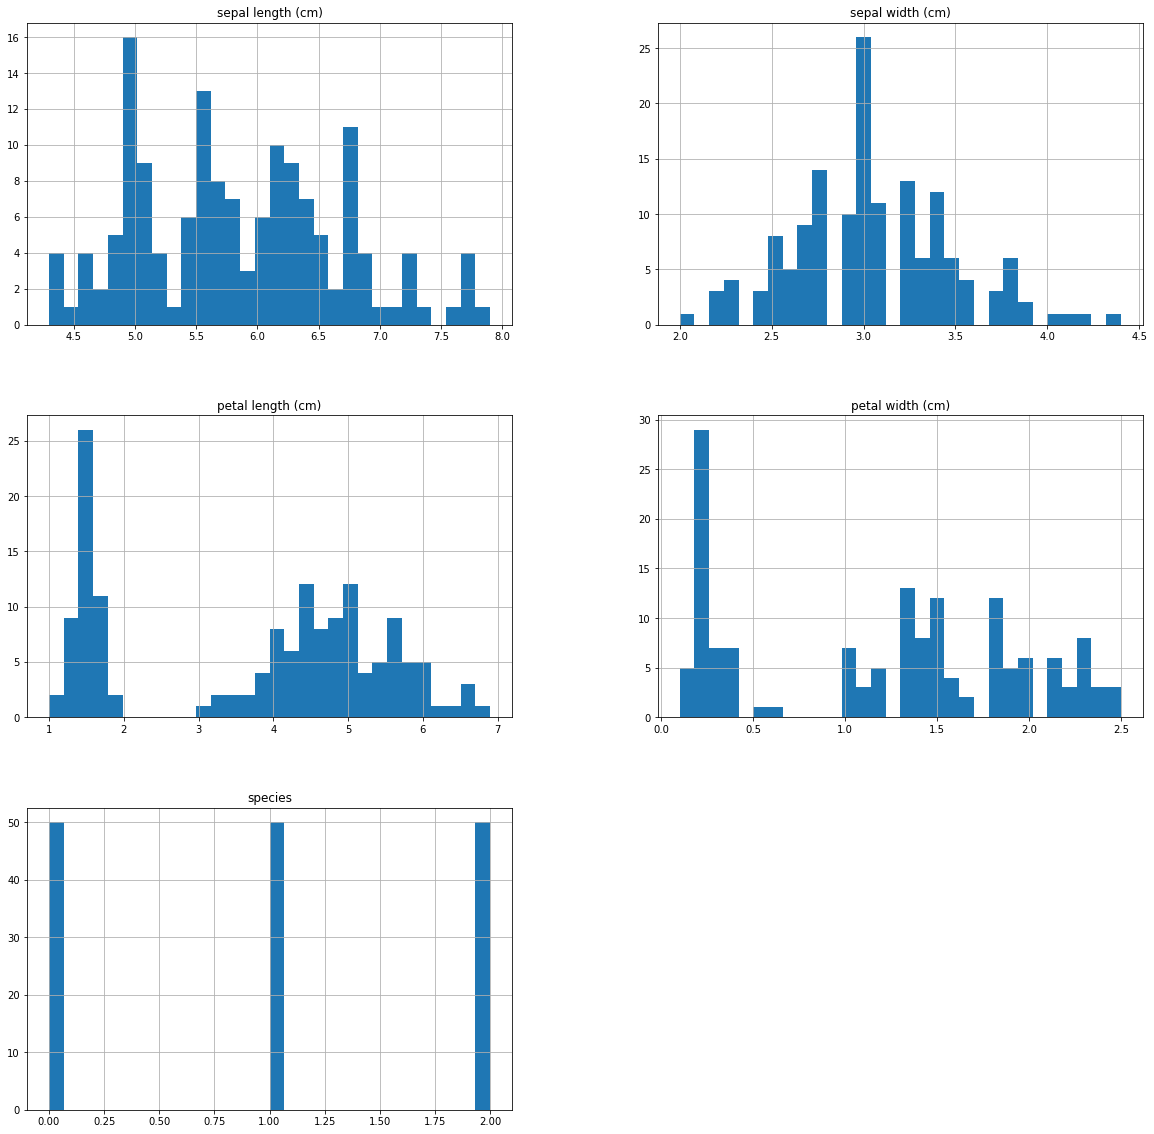

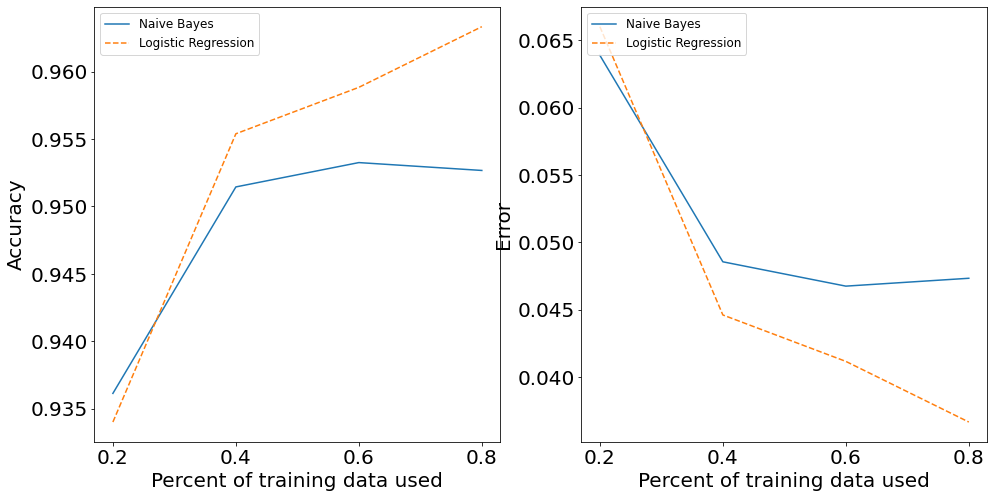

In [8]:
import warnings
warnings.filterwarnings("ignore")

from IPython.display import clear_output

from sklearn.datasets import load_iris
iris_obj = load_iris()

# Transforming the iris dataset to a dataframe
iris = pd.DataFrame(iris_obj.data, columns=iris_obj.feature_names,index=pd.Index([i for i in range(iris_obj.data.shape[0])])).join(pd.DataFrame(iris_obj.target, columns=pd.Index(["species"]), index=pd.Index([i for i in range(iris_obj.target.shape[0])])))
iris.info()

# Data understanding 
## Visualize the data 
iris.hist(bins=30,figsize=(20,20))

## Feature/label correlation check
corr_matrix=iris.corr(); print(corr_matrix)
corr_matrix["species"].sort_values(ascending=False)

# Preparing the data
##Transforming the feature 'species' as category instead of integer which goes to infinity 
iris['species'] = iris['species'].astype('category')

## split label and design matrix
### define the design matrix
X = iris.drop("species", axis=1) 
y = iris["species"] 

X_data = X.to_numpy()
y_data = y.to_numpy()

nbc_iris = NBC(feature_types=['r', 'r', 'r', 'r'], num_classes=3)
lr_iris = LR()

compareNBCvsLR(nbc_iris, lr_iris, X_data, y_data, 200, 5)



## 2.2: Voting Dataset

https://archive.ics.uci.edu/ml/datasets/congressional+voting+records


**Data Understanding**<br/> By looking at the histograms, we do not see action which is needed. Furthermore the correlation matrix shows that almost all features are correlated with the label (except feature 2 and 10, which appear to have a very weak correlation).

**Data Preparation**<br/> We are taking care of the missing values by dropping the rows with missing information. As soon as we do that we obtain 232 entries for each attribute. By checking the attributes and the label, we observe that all the attributes are coded yes/no and the label as republican/democrat, hence we can use the ordinal encoder to convert the object features as 0/1.

**Comparison NBC and LR**<br/> The below plots show that the logistic regression outperforms the NBC at any trainings set size, though the errors of both classifiers are decreasing with increasing training data size. Also here it seems as if the performance is consistent with the theoretical beliefs about the asymtotic error of the logistic regression being relatively smaller.In general both classifiers are performing very good on this data set.

In [ ]:
# Load dataset
voting = pd.read_csv('./datasets/voting.csv')

# Inspect features and classes
voting.info()

#Data preparation
##Dropping NaN's from the data and endcoding the attributes/the label
voting=voting.dropna()
voting = pd.DataFrame(ordinal_encoder.fit_transform(voting))

# Inspect features and classes, after dropping observations with missing values
voting.info(verbose=1)

#Data understanding
##Looking at the histograms 
voting.hist(bins=30,figsize=(20,20))

##Checking correlations
#corr_matrix=voting.corr(); print(corr_matrix)
#corr_matrix[0].sort_values(ascending=False)

#Data preparation
## split label and design matrix
### define the design matrix
X_voting_data = voting.drop(0, axis=1).to_numpy()
### define the label 
y_voting_data = voting[0].to_numpy()

nbc_voting = NBC(feature_types=['b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b'], num_classes=2)
lr_voting = LR()

compareNBCvsLR(nbc_voting, lr_voting, X_voting_data, y_voting_data, 200, 5)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435 entries, 0 to 434
Data columns (total 17 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   label                                   435 non-null    object
 1   handicapped-infants                     423 non-null    object
 2   water-project-cost-sharing              387 non-null    object
 3   adoption-of-the-budget-resolution       424 non-null    object
 4   physician-fee-freeze                    424 non-null    object
 5   el-salvador-aid                         420 non-null    object
 6   religious-groups-in-schools             424 non-null    object
 7   anti-satellite-test-ban                 421 non-null    object
 8   aid-to-nicaraguan-contras               420 non-null    object
 9   mx-missile                              413 non-null    object
 10  immigration                             428 non-null    object
 11  synfue

## 2.3: Car Evaluation Dataset

https://archive.ics.uci.edu/ml/datasets/car+evaluation

**Data Understanding**<br/> The correlation matrix reveals that the attributes are uncorrelated with each other, however correlated with the label. The histograms reveal that all attributes have a uniform distribution.

**Data Preparation**<br/> All the attributes including the label 'acceptability' are objects and need to be converted into numbers. It makes sense to convert the label into a categorical variable, where increasing numbers have a meaning. Since also all the attributes have ordered categories, we can convert them into catgorical varaibles with increasing numbers using the ordinal encoder.

**Comparison NBC and LR**<br/> Contrary to the belief held, we see that for any training data size the NBC outperforms the logistic regression, even when the trainings size approaches its maximum size. Furthermore the logistic regression does not improve by increasing the trainings data size, while the NBC slightly improves. However if we look a bit closer into the X matrix (matric of features), we see that they are totally independant, which is an assumption of the NBC. Hence it is reasonable why the NBC outperforms by far. 

In [ ]:
# Six input features: 
# F1. buying 
# F2. maint
# F3. doors
# F4. persons
# F5. lug_boot
# F6. safety
# Output acceptability
#
car = pd.read_csv('./datasets/car.csv')
car.info()

# Inspect values for every individual feature
for feature_name, feature_values in car.iteritems():
    # F1. buying => ['vhigh' 'high' 'med' 'low'] #4
    # F2. maint => ['vhigh' 'high' 'med' 'low'] #4
    # F3. doors => ['2' '3' '4' '5more'] #4
    # F4. persons => ['2' '4' 'more'] #3
    # F5. lug_boot => ['small' 'med' 'big'] #3 
    # F6. safety => ['low' 'med' 'high'] #3
    # L   acceptability => ['unacc' 'acc' 'vgood' 'good'] #4
    print("%s => %s" % (feature_name, feature_values.unique()))

num_classes = len(car['acceptability'].unique())
print(num_classes)
print(car.head(10))
#print("Buying => %s" % (car['buying'].unique()))
#print("Maint => %s" % (car['maint'].unique()))
#print("Doors => %s" % (car['doors'].unique()))
#print("Persons => %s" % (car['persons'].unique()))
#print("safety => %s" % (car['safety'].unique()))
#print("Acceptability => %s" % (car['acceptability'].unique()))

#print("Acceptability => %s" % (car['acceptability'].unique()))


#Data Preparation
##Encoding the data set into categorical attributes
car = car.astype('category')
car['buying'] = car['buying'].cat.codes
car['maint'] = car['maint'].cat.codes
car['doors'] = car['doors'].cat.codes
car['persons'] = car['persons'].cat.codes
car['lug_boot'] = car['lug_boot'].cat.codes
car['safety'] = car['safety'].cat.codes
car['acceptability'] = car['acceptability'].cat.codes
car.info()

#Data Understanding
##Looking at the histograms 
car.hist(bins=30,figsize=(20,20))

##Checking correlations
corr_matrix=car.corr(); print(corr_matrix)
corr_matrix["acceptability"].sort_values(ascending=False)

#Data preparation
## split label and design matrix
### define the design matrix
X_car_data = car.drop("acceptability", axis=1).to_numpy()
### define the label 
print("Car_data_shape", X_car_data.shape)
y_car_data = car["acceptability"].to_numpy()

from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X_car_data, y_car_data, test_size=0.2, random_state=42)
nbc_car_evaluation = NBC(feature_types=['c', 'c', 'c', 'c', 'c', 'c'], num_classes=num_classes)
lr_car_evaluation = LR()

compareNBCvsLR(nbc_car_evaluation, lr_car_evaluation, X_car_data, y_car_data, 200, 5)



## 2.4: Breast Cancer Dataset

https://archive.ics.uci.edu/ml/datasets/breast+cancer


**Data Understanding**<br/> Looking at the histogram, we do not observe heavy tails, nor something which calls for adjustments. Furthermore we observe by looking at the correlation matrix that feature 8 and 9 are only weakly correlated with the the Class label, hence those features are maybe worth considered dropping.

**Data Preparation**<br/> By looking into more depth into each of the features, we can observe that the attribute node-caps has 8 and breast-quad has 1 missing values, which we all dropped. We have to encode the object features into numerical values. By checking the levels of the features we observe that age, tumor-size, irradiat, class, inv-nodes, breast and node-caps can be converted using a ordinal converter because their categories are either ordianl or binary. The other 3 features are encoded using One-Hot-Encoding.

**Comparison NBC and LR**<br/> For the breast cancer data set we see that both classifiers are performing quite similar. Both are performing not optimal.


In [ ]:
cancer = pd.read_csv('./datasets/breast-cancer.csv')
#cancer.info()

# Data preparation
##Dropping missing values (marked by ?)
indexNames = cancer[ cancer['node-caps'] == '?'].index
cancer.drop(indexNames , inplace=True)
indexNames2 = cancer[cancer['breast-quad'] == '?'].index
cancer.drop(indexNames2 , inplace=True)
cancer = cancer.reset_index(drop=True)

## Encoding object features
cancer= cancer.astype('category')
cancer['age'] = cancer['age'].cat.codes
cancer['tumor-size'] = cancer['tumor-size'].cat.codes
cancer['irradiat'] = cancer['irradiat'].cat.codes
cancer['Class'] = cancer['Class'].cat.codes
cancer['inv-nodes'] = cancer['inv-nodes'].cat.codes
cancer['breast'] = cancer['breast'].cat.codes
cancer['node-caps'] = cancer['node-caps'].cat.codes
cancer_cat = cancer[["menopause","deg-malig","breast-quad"]]
cancer_cat_encoded = one_hot_encoder.fit_transform(cancer_cat) 
cancer_cat_encoded = pd.DataFrame(cancer_cat_encoded.toarray())
cancer = pd.concat([cancer, cancer_cat_encoded], axis=1)
cancer = cancer.drop(["menopause","deg-malig","breast-quad"], axis=1)

# Data understanding
##Looking at the histograms 
cancer.hist(bins=30,figsize=(20,20))

##Checking correlations
corr_matrix=cancer.corr(); print(corr_matrix)
corr_matrix["Class"].sort_values(ascending=False)

#Data preparation
## split label and design matrix
### define the design matrix
X = cancer.drop("Class", axis=1) 
### define the label 
y = cancer["Class"] 

X_data = X.to_numpy()
y_data = y.to_numpy()

# Comparing both classifiers
nbc_cancer = NBC(feature_types=np.concatenate((np.repeat('r',3),np.repeat('b',14))), num_classes=2)
lr_cancer = LR()
compareNBCvsLR(nbc_cancer, lr_cancer, X_data, y_data, 200, 5)


## 2.5: Ionosphere Dataset

https://archive.ics.uci.edu/ml/datasets/ionosphere


**Data Understanding**<br/> The histograms show no heavy tails, hence no log transformation is necessary. Furthermore it can be observed that feature 2 takes only the value 0, therefore we excluded the feature since no beneficial variation can be extracted by including that feature.

**Data Preparation**<br/> From the info output we can observe that there are no missing values, hence we do not have to deal with them. Since the label is an object and machine learning methods work with numbers, we converted the label (coded as g or b) into 0/1.

**Comparison NBC and LR**<br/> The logistic regression is clearly outperfoming on the Ionosphere Dataset.We observe that the NBC approaches faster his asymptotic eroor and keeps being constant afterwards, which is consistent with the 2nd commonly held belief. What is expected and what we can observe additionally is that the error of the logistic regression is lower than the error of the NBC with increasing trainings data size.


In [ ]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

#Load data
ionosphere = pd.read_csv('./datasets/ionosphere.csv')
ionosphere.info()

# Data Preparation
##Convert label into category
ionosphere['label'].value_counts()
ionosphere['label'] = ionosphere['label'].astype('category')
ionosphere['label'] = ionosphere['label'].cat.codes
ionosphere.info()

##Understanding the data set
#Looking at the histograms and excluding feature 2
ionosphere.hist(bins=30,figsize=(20,20))
ionosphere = ionosphere.drop("feature2", axis=1)

#Checking correlations
corr_matrix=ionosphere.corr(); print(corr_matrix)
corr_matrix["label"].sort_values(ascending=False)

#Data preparation
## split label and design matrix
### define the design matrix
X = ionosphere.drop("label", axis=1) 
### define the label 
y = ionosphere["label"]

X_data = X.to_numpy()
y_data = y.to_numpy()

# Comparing both classifiers
nbc_ionosphere = NBC(feature_types=np.concatenate((np.array(['b']),np.repeat('r',32))), num_classes=2)
lr_ionosphere = LR()
compareNBCvsLR(nbc_ionosphere, lr_ionosphere, X_data, y_data, 200, 5)

## 2.6: Sonar Dataset

http://archive.ics.uci.edu/ml/datasets/connectionist+bench+%28sonar,+mines+vs.+rocks%29

**Data Understanding**<br/> As we can see from the correlation matrix, there are 3 features (57, 17, 30 and some more) which have a really weak correlation with the label. That might be of concern for out analysis and hence we exclude them from the data set, since they seem unnecessary and the classifiers tend to overfit with too many features. The histogram reveal some insights, namely that some features should be log transformed since their histograms are heavy tailed. This issue concerns features 1-6, 44, 46-60. Furthermore we cannot observe that one feature is capped at some value.

**Data Preparation**<br/> There are no feature transformation needed, since all features are numerical. Furthermore there are no missing values.

In [ ]:
sonar = pd.read_csv('./datasets/sonar.csv')
sonar.info()

# Getting a data understanding 
sonar['label'].value_counts()
## Visualize the data 
sonar.hist(bins=30,figsize=(20,20))

## Checking correlations
corr_matrix=sonar.corr(); print(corr_matrix)
corr_matrix["label"].abs().sort_values(ascending=True)

# Data preparation
##Taking log of features which are tail heavy
sonar_log1 = np.log(sonar.iloc[:, 0:5])
sonar_log2 = np.log(sonar.iloc[:, 42])
sonar_log3 = np.log(sonar.iloc[:, 45:58])
sonar = sonar.drop(sonar.iloc[:, 0:5], axis=1)
sonar = sonar.drop("feature43", axis=1)
sonar = sonar.drop(sonar.iloc[:,39:53], axis=1)
sonar = pd.concat([sonar, sonar_log1, sonar_log2,sonar_log3], axis=1)

## split label and design matrix
### define the design matrix
X = sonar.drop("label", axis=1) 
### define the label 
y = sonar["label"] 
